## Delta[HHB2] Single Branch ANN Fitting

In [7]:
import pandas as pd
import glob
import os
import numpy as np
import sys
! pip install pmcx

In [8]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from FD_msNIRS_2layers import extract_freq as ef

### Read Simulation data

In [10]:
import os
import pickle
import numpy as np

In [11]:
result_folder1 = '/content/drive/MyDrive/MCX_data/result_folder/part1/'
result_folder2 = '/content/drive/MyDrive/MCX_data/result_folder/part2/'
result_folder3 = '/content/drive/MyDrive/MCX_data/result_folder/part3/'
result_folder4 = '/content/drive/MyDrive/MCX_data/result_folder/part4/'
result_folder5 = '/content/drive/MyDrive/MCX_data/MCX_sim_data/1-4/Results/'
result_folders = [result_folder1, result_folder2, result_folder3, result_folder4, result_folder5]

In [12]:
def row_construct(dictt):
    re = np.zeros((1, 96))
    col = 0
    for k, v in dictt.items():  # four distances
        TPSF_list = v
        uac_i, udc_i, p1 = ef(110e6, TPSF_list, tend=1e-08, devf=1000)  # 8 wavelengths
        combined = []
        for i in range(8):
            combined.extend([uac_i[i], udc_i[i], p1[i]])  # Interleave the values
        re[0, col:col+24] = combined  # Each set contributes 24 values
        col += 24
    return re

In [13]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def extract_id_from_path(path):
    filename = os.path.basename(path)
    return int(filename.replace('.pkl', ''))

def load_and_construct(path):
    with open(path, 'rb') as f:
        dictt = pickle.load(f)
    return row_construct(dictt)

def load_and_process_all(result_folders):
    # Collect all file paths
    file_paths = []
    for folder in result_folders:
        for f in os.listdir(folder):
            if f.endswith('.pkl'):
                file_paths.append(os.path.join(folder, f))

    # Sort by numeric filename
    sorted_paths = sorted(file_paths, key=extract_id_from_path)
    sorted_ids = [extract_id_from_path(p) for p in sorted_paths]

    # Load and process in parallel (with progress bar)
    all_rows = []
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_and_construct, sorted_paths), total=len(sorted_paths), desc="Loading and processing files"))

    result_array = np.vstack(results)
    return result_array, sorted_ids

In [14]:
final_array, sorted_ids = load_and_process_all(result_folders)

Loading and processing files:   1%|          | 19/2000 [00:01<02:06, 15.62it/s]

KeyboardInterrupt: 

In [ ]:
final_array.shape

In [ ]:
# Save to CSV
output_csv_path = '/content/drive/MyDrive/MCX_data/stage1.csv'
pd.DataFrame(final_array).to_csv(output_csv_path, index=False, header=False)

In [ ]:
final_array.shape

### Read the saved CSV

In [17]:
import pandas as pd
import glob
import numpy as np
import sys
! pip install pmcx
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
import os
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
csv_path = '/content/drive/MyDrive/MCX_data/stage1.csv'
final_array = np.loadtxt(csv_path, delimiter=',')
print(final_array.shape)

(2000, 96)


### GT

In [19]:
GT_folder = '/content/drive/MyDrive/MCX_data/csv/'

In [20]:
csv_files = glob.glob(os.path.join(GT_folder, '*.csv'))
GT_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [21]:
GT_all.head()

HBO1       HHB1       HBO2      HHB2    d1        a1        a2  \
0  10.618102  12.007143  46.959818  26.97317  12.0  1.835967  1.280059   
1  18.118102   7.007143  31.959818  16.97317  17.0  4.835967  2.830059   
2   6.868102   4.507143  39.459818  31.97317  19.0  3.335967  3.605059   
3  14.368102   9.507143  54.459818  21.97317  14.0  6.335967  2.055059   
4  16.243102   5.757143  35.709818  29.47317  10.0  1.085967  1.667559   

         b1        b2  ID  
0  2.178823  2.103345   1  
1  0.978823  0.603345   2  
2  0.378823  2.853345   3  
3  1.578823  1.353345   4  
4  1.278823  2.478345   5

In [24]:
sorted_ids = [i+1 for i in range(2000)]

In [26]:
sorted_ids[-1]

2000

In [27]:
# Ensure ID column is integer
GT_all['ID'] = GT_all['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all[GT_all['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

# Extract HHB2 as Y
Y = GT_filtered['HHB2'].values  # numpy array (n_samples,)
Y = Y.reshape(-1, 1)

In [28]:
Y.shape

(2000, 1)

In [29]:
X = final_array

In [30]:
X.shape

(2000, 96)

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale X
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Scale Y
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

### Create Data Pair: [X1 , X2] = Y1 - Y2

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Step 2: Pairing function
def generate_pairs(X1, Y1, X2=None, Y2=None):
    X_pairs = []
    Y_diffs = []

    if X2 is None:
        # Pair within the same set (X1 vs X1)
        for i in range(len(X1)):
            for j in range(len(X1)):
                x_pair = np.concatenate([X1[i], X1[j]])
                y_diff = Y1[i, 0] - Y1[j, 0]
                X_pairs.append(x_pair)
                Y_diffs.append(y_diff)
    else:
        # Pair across different sets (X1 vs X2)
        for i in range(len(X1)):
            for j in range(len(X2)):
                x_pair = np.concatenate([X1[i], X2[j]])
                y_diff = Y1[i, 0] - Y2[j, 0]
                X_pairs.append(x_pair)
                Y_diffs.append(y_diff)

    return np.array(X_pairs), np.array(Y_diffs).reshape(-1, 1)

# Step 3: Generate all combinations
X_train_pairs, Y_train_diffs = generate_pairs(X_train, Y_train)                    # train vs train
X_test_pairs, Y_test_diffs = generate_pairs(X_test, Y_test)                        # test vs test
X_cross_pairs, Y_cross_diffs = generate_pairs(X_train, Y_train, X_test, Y_test)    # train vs test

# Step 4: Print results
print("Train pairs:", X_train_pairs.shape, Y_train_diffs.shape)
print("Test pairs:", X_test_pairs.shape, Y_test_diffs.shape)
##print("Cross pairs:", X_cross_pairs.shape, Y_cross_diffs.shape)

Train pairs: (3240000, 192) (3240000, 1)
Test pairs: (40000, 192) (40000, 1)


In [33]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1800, 96) (200, 96) (1800, 1) (200, 1)


### ANN

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout


model = Sequential([
    Input(shape=(192,)),
    Dense(192, activation='relu'),
    Dropout(0.2),

    Dense(2048, activation='relu'),
    Dropout(0.3),

    Dense(4096, activation='relu'),
    Dropout(0.3),

    Dense(8192, activation='relu'),
    Dropout(0.3),

    Dense(4096, activation='relu'),
    Dropout(0.3),

    Dense(2048, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(512, activation='relu'),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(1)  # Output layer for regression
])


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1.5e-5)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train_pairs, Y_train_diffs, epochs=150, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 193s 9ms/step - loss: 1.8997 - val_loss: 1.5359
Epoch 2/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/step - loss: 1.4927 - val_loss: 1.0949
Epoch 3/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/step - loss: 1.1375 - val_loss: 0.8951
Epoch 4/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 155s 8ms/step - loss: 0.9127 - val_loss: 0.8189
Epoch 5/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - loss: 0.7809 - val_loss: 0.8120
Epoch 6/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - loss: 0.6886 - val_loss: 0.7701
Epoch 7/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - loss: 0.6181 - val_loss: 0.7642
Epoch 8/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - loss: 0.5571 - val_loss: 0.7565
Epoch 9/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 155s 8ms/step - loss: 0.5083 - val_loss: 0.7232
Epoch 10/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - loss: 0.4639 - val_loss: 0.7167
Epoch 11/150
20250/20250 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/step - loss: 0

KeyboardInterrupt: 

In [84]:
# Predict and evaluate
y_pred = model.predict(X_test_pairs)
mse = mean_squared_error(Y_test_diffs, y_pred)
print(f"Test MSE: {mse:.4f}")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test MSE: 1.3109


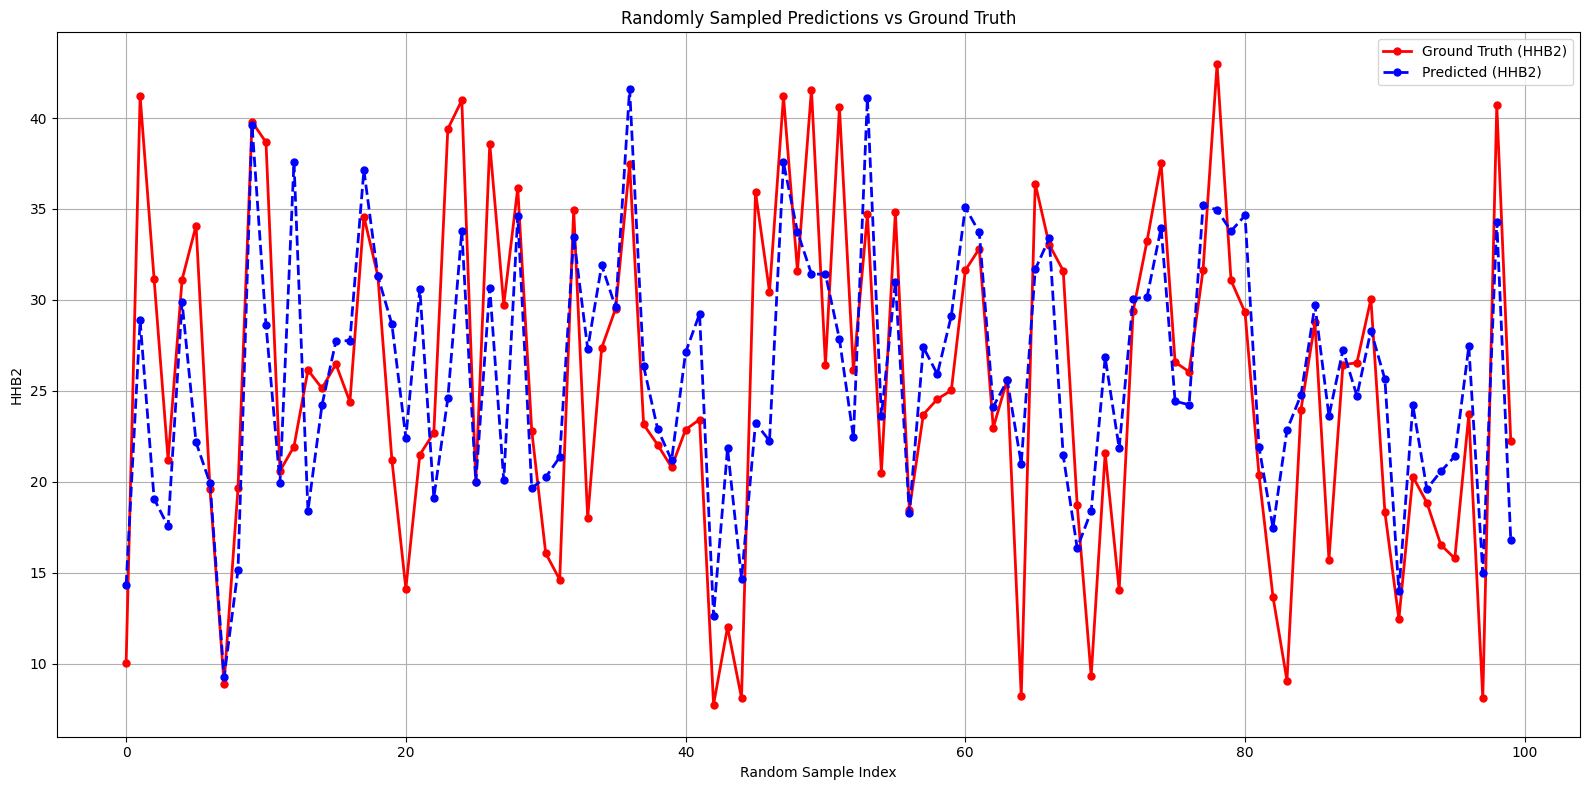

In [85]:
# Randomly select 100 indices
indices = np.random.choice(len(Y_test_diffs), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test_diffs.reshape(-1, 1)).flatten()

# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 43.6977


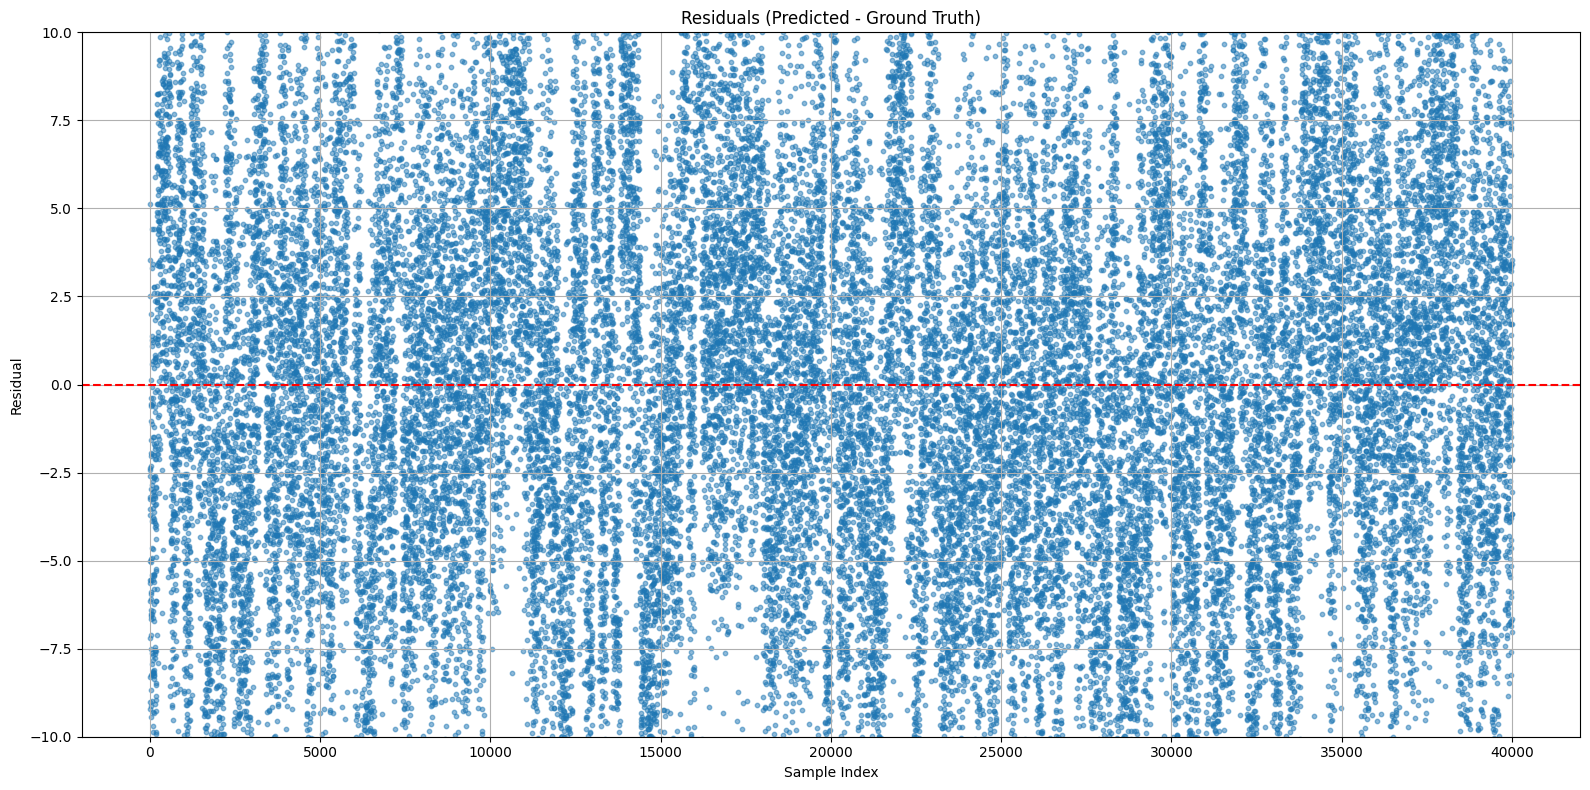

In [86]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test_diffs)     # shape (n, 1)

# Compute residuals in original scale
residuals = y_pred_orig - y_test_orig

mse_rescaled = mean_squared_error(y_test_orig, y_pred_orig)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

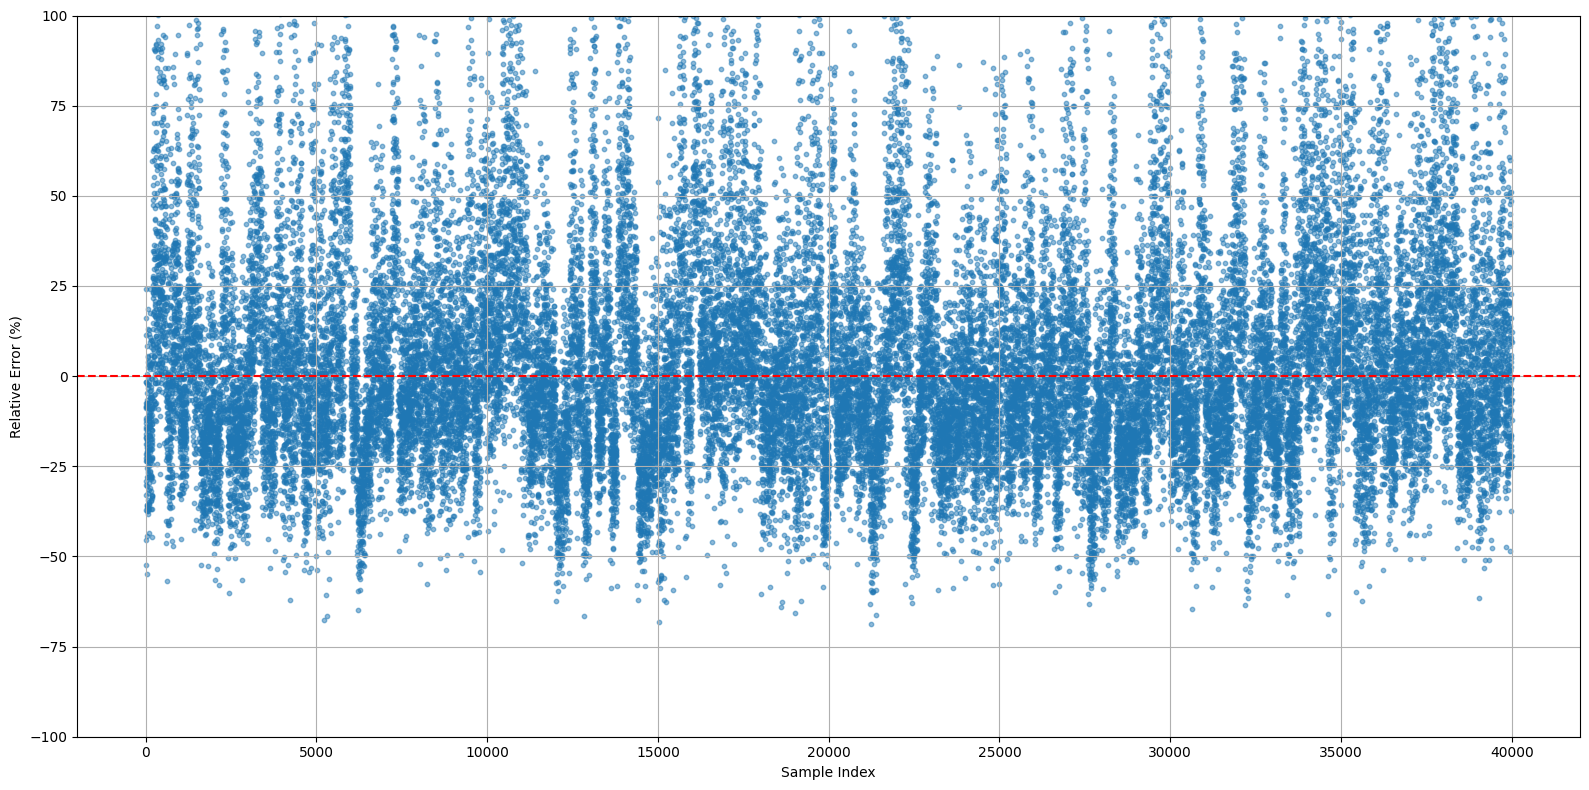

In [87]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test_diffs)     # shape (n, 1)

# Compute relative error (percentage)
relative_error = ((y_pred_orig - y_test_orig) / y_test_orig) * 100

# Plot relative error
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel("Relative Error (%)")
plt.ylim(-100, 100)  # Adjust range as needed
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()


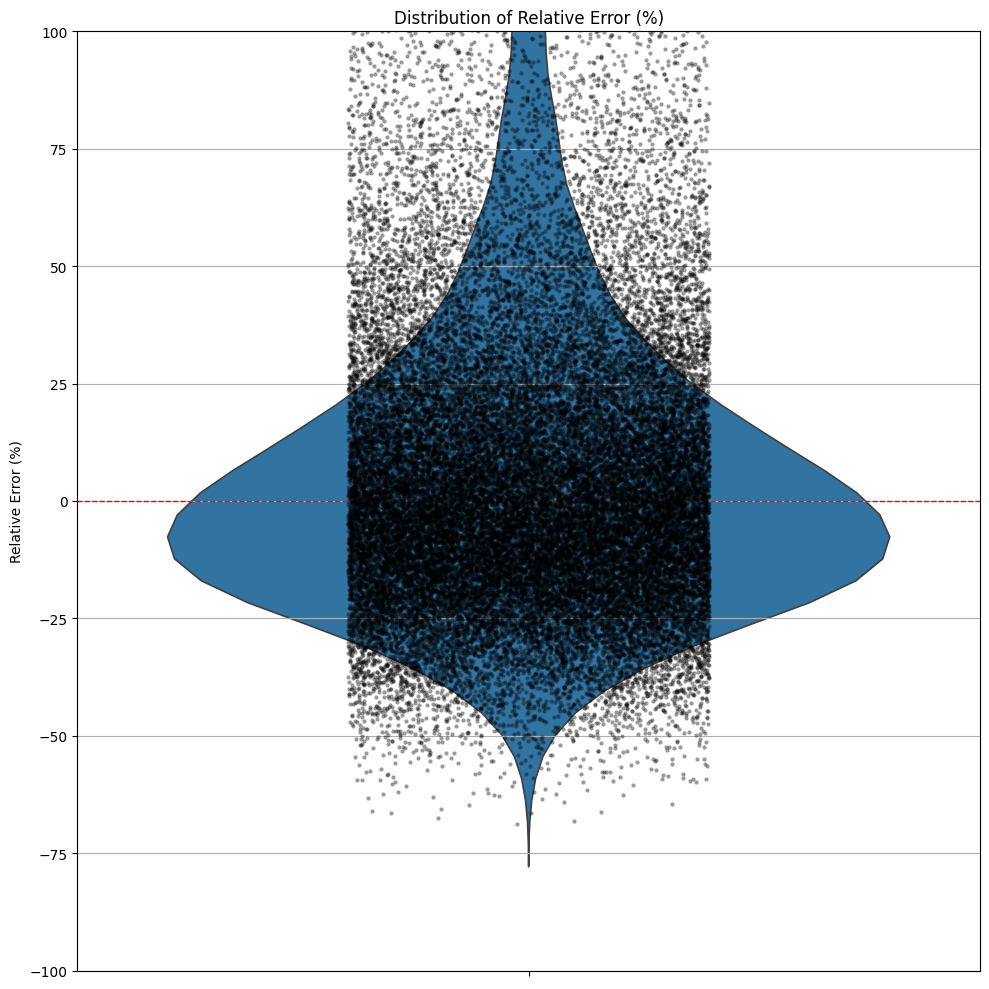

In [88]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for seaborn
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(10, 10))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


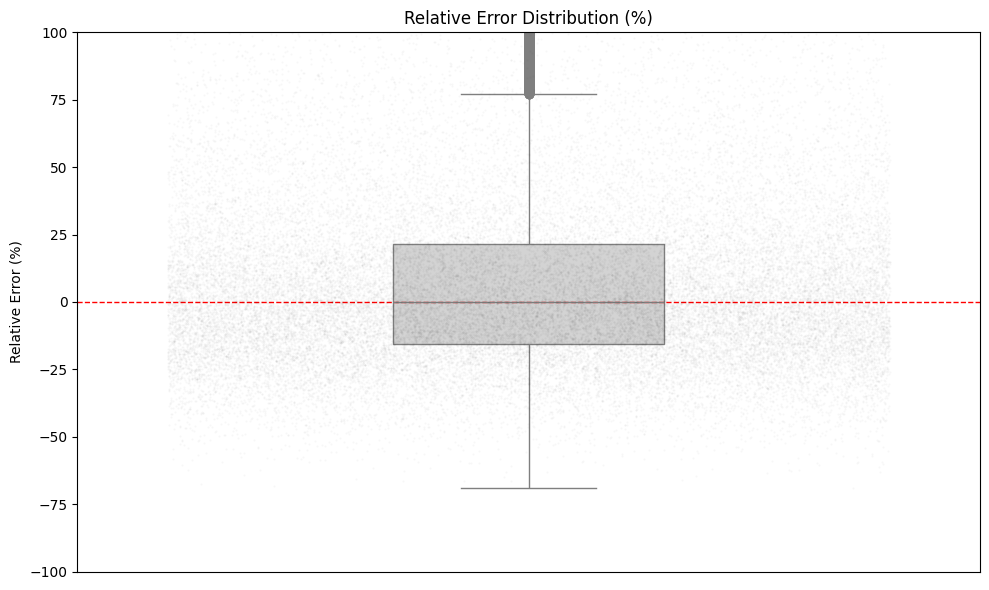

In [89]:
relative_error = relative_error.squeeze()

plt.figure(figsize=(10, 6))
sns.boxplot(y=relative_error, color='lightgray', width=0.3)
sns.stripplot(y=relative_error, color='black', alpha=0.03, jitter=0.4, size=1.5)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Relative Error Distribution (%)')
plt.ylabel('Relative Error (%)')
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


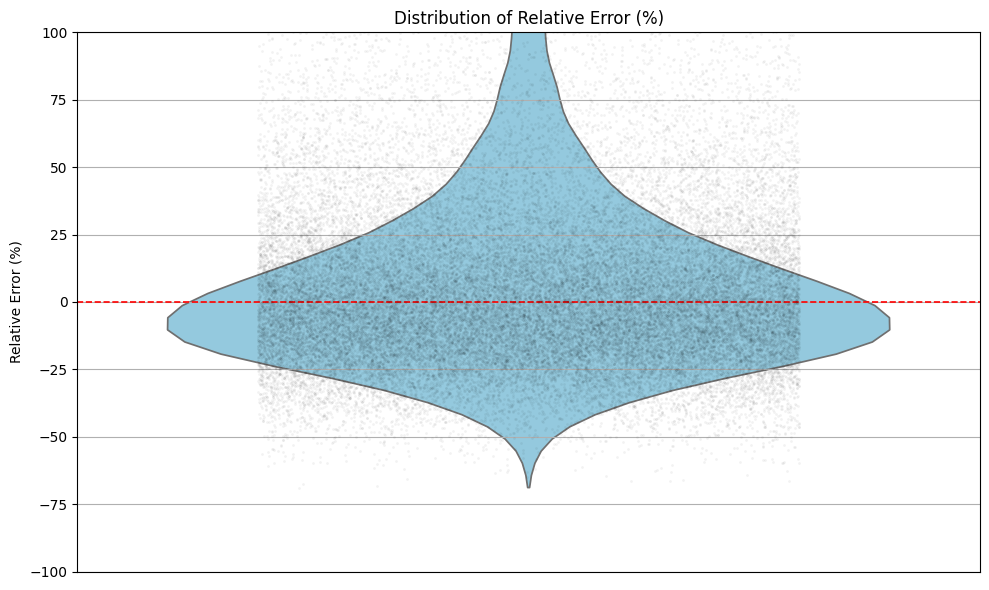

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.violinplot(y=relative_error, inner=None, color='skyblue', cut=0)
sns.stripplot(y=relative_error, color='black', alpha=0.05, jitter=0.3, size=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.title('Distribution of Relative Error (%)')
plt.ylabel('Relative Error (%)')
plt.grid()
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


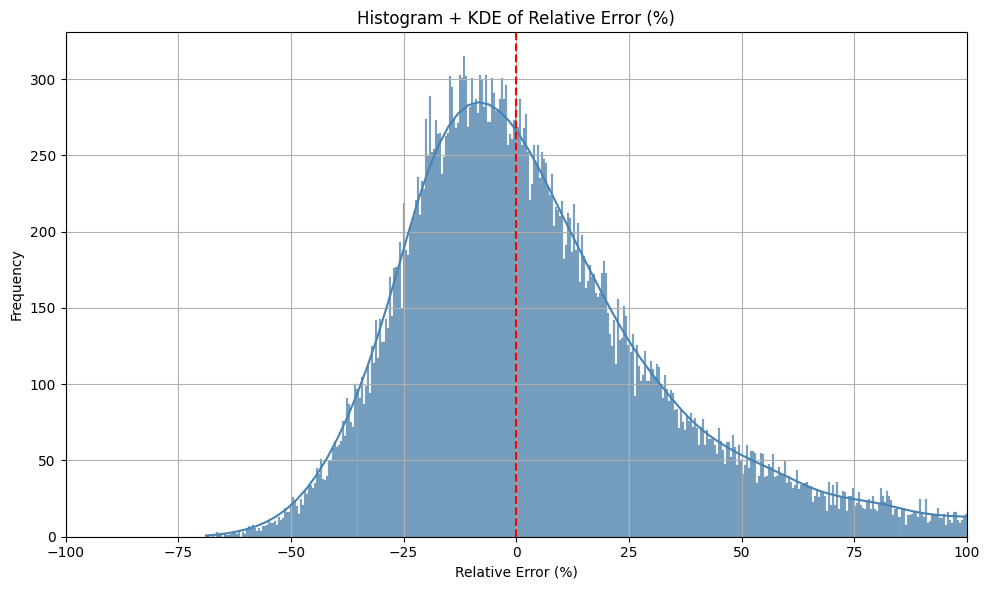

In [91]:
plt.figure(figsize=(10, 6))
sns.histplot(relative_error, kde=True, bins=1000, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram + KDE of Relative Error (%)")
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.grid()
plt.xlim(-100, 100)
plt.tight_layout()
plt.show()

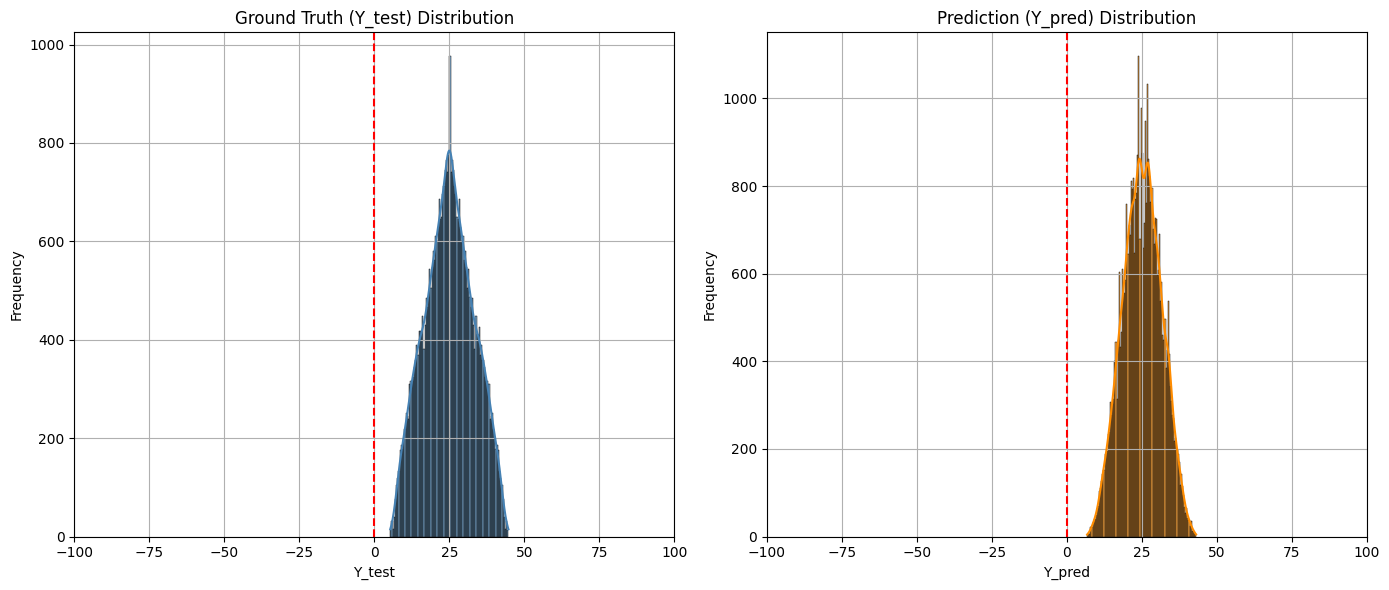

In [92]:
plt.figure(figsize=(14, 6))

# Subplot 1: Ground truth
plt.subplot(1, 2, 1)
sns.histplot(np.asarray(y_test_orig).ravel(), kde=True, bins=100, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Ground Truth (Y_test) Distribution")
plt.xlabel("Y_test")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

# Subplot 2: Prediction
plt.subplot(1, 2, 2)
sns.histplot( np.asarray(y_pred_orig).ravel(), kde=True, bins=100, color='darkorange', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Prediction (Y_pred) Distribution")
plt.xlabel("Y_pred")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

plt.tight_layout()
plt.show()

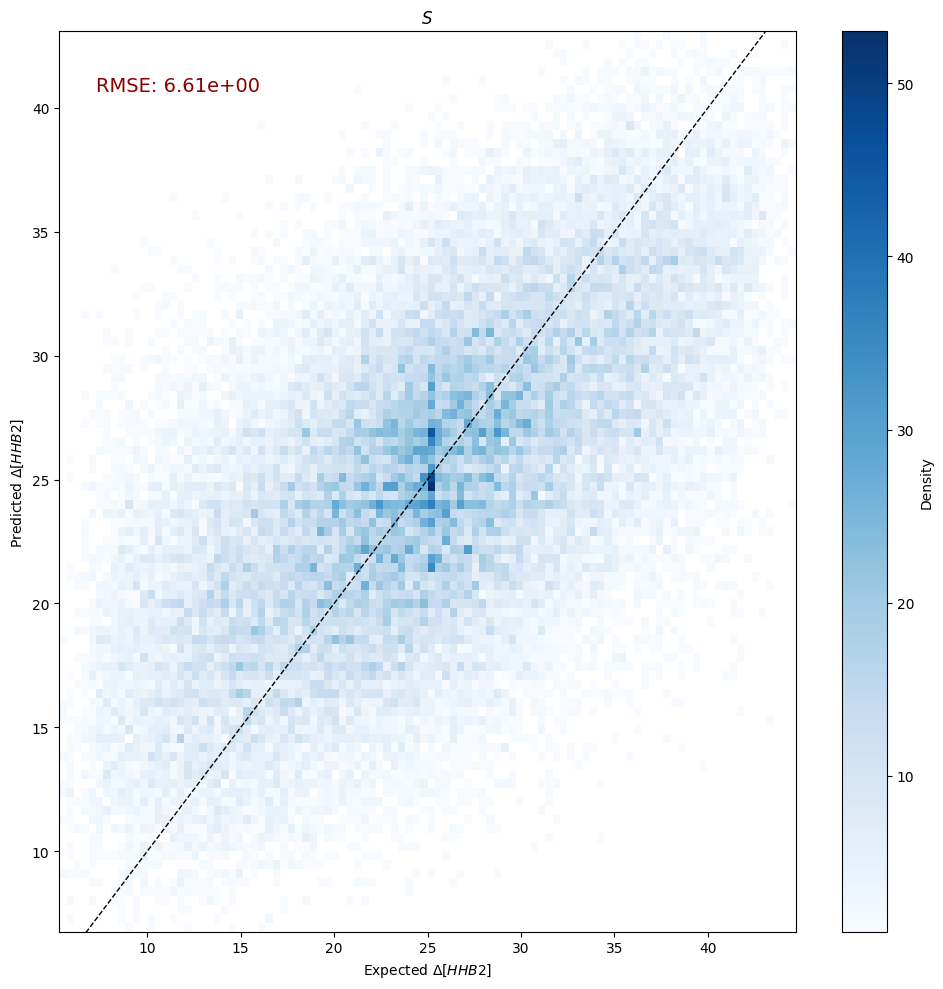

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure y_true and y_pred are 1D numpy arrays
y_true = np.asarray(y_test_orig).ravel()
y_pred =np.asarray(y_pred_orig).ravel()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Plot
plt.figure(figsize=(10, 10))
plt.hist2d(y_true, y_pred, bins=100, cmap='Blues', cmin=1)

# Plot identity line
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         'k--', lw=1)

# Labels and title
plt.xlabel('Expected $\Delta[HHB2]$')
plt.ylabel('Predicted $\Delta[HHB2]$')
plt.title(r'$S$')

# Annotate RMSE
plt.text(0.05, 0.95, f'RMSE: {rmse:.2e}', color='darkred',
         fontsize=14, transform=plt.gca().transAxes, va='top')

plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

In [94]:
# Small epsilon to avoid division by zero
eps = 1e-8

# Relative error (%)
relative_error = (y_pred - y_true) / (y_true + eps) * 100
absolute_relative_error = np.abs(relative_error)

# Compute metrics
mre = np.mean(relative_error)
mape = np.mean(absolute_relative_error)

# Print
print(f"Mean Relative Error (MRE): {mre:.4f}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Relative Error (MRE): 8.1725%
Mean Absolute Percentage Error (MAPE): 25.5993%
